## Playing with PUDL
This notebook is meant to help get you up and running with the PUDL database, so you can play with it!

### Importing external code.
We need to import a bunch of outside code to do our work here.  Sometimes we import entire packages (like `numpy` and `pandas`) and sometimes we just pull in a couple of pieces we need from a particular part of a large package (like `declarative_base`)

In [1]:
import sys
import os.path
import numpy as np
import pandas as pd
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from sqlalchemy.engine.url import URL
import matplotlib.pyplot as plt
import datetime as dt

### Importing our own code
We also need to tell Python where to look to find our own code.  It has a list of directories that it looks in, but our little project isn't in that list, unless we add it -- which is what `sys.path.append()` does.  You'll need to change this path to reflect where on your computer the PUDL project folder (which you pull down with `git`) lives.

Once Python knows to look in the `pudl` project folder, it will let you import `pudl` modules just like any other Python module.  Here we're pulling in the `ferc1` and `pudl` modules from the `pudl` package (which is a directory inside the `pudl` project directory).

In [2]:
sys.path.append('/Users/christinagosnell/code/pudl')
sys.path.append('/Users/zaneselvans/code/catalyst/pudl')
sys.path.append('/Users/Nannerz/Desktop/working/pudl/')
sys.path.append('/home/alana/Dropbox/catalyst/pudl')
from pudl import ferc1, pudl, models, models_ferc1, settings, constants

### Automatically reloading a work in progress
Because you're probably going to be editing the Python modules related to PUDL while you're working with this notebook, it's useful to have them get automatically reloaded before every cell is executed -- this means you're always using the freshest version of the module, with all your recent edits.

In [77]:
%load_ext autoreload
%autoreload 1
%aimport pudl.pudl
%aimport pudl.ferc1
%aimport pudl.constants
%aimport pudl.settings
%aimport pudl.models

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Connecting to our databases.
We have two different databases that we're working with right now.  The FERC Form 1 (`ferc1`) and our own PUDL database (`pudl`). For this software to work, you'll need to have the Postgresql database server running on your computer, and you'll need to have created empty databases to receive the tables and data we're going to create.  On a mac, the easiest Postgres install to get running is probably Postgress.app.  You'll need to fire it up at the command line at least once to create the databases (one called `ferc1` and another called `pudl_sandbox`) and a user named `catalyst` with no password.  This information is stored in the `settings` module if you need to look it up.

Here are two shortcuts for connecting to the two databases once they're created:

In [4]:
pudl_engine  = pudl.pudl.db_connect_pudl()
ferc1_engine = pudl.ferc1.db_connect_ferc1()

### Initialized the FERC Form 1 database
Now that you've got an empty database, let's put some data in it!  This function initializes the database by reading in the FERC Form 1 database structure from `refyear` and data from `years` (which can eventually be a list of years, but that's not working yet...). In order for this to work, you need to have the FERC Form 1 data downloaded into the data directory. There's a script called `get_ferc1.sh` down in `data/ferc/form1/` that will get it for you if you don't have it.

In [5]:
pudl.ferc1.init_db(refyear=2015, years=[2007,2008,2009,2010,2011,2012,2013,2014,2015], ferc1_tables=pudl.constants.ferc1_default_tables)

Defining new FERC Form 1 DB based on 2015...
Clearing any existing FERC Form 1 database MetaData...
Ingesting FERC Form 1 Data from 2007...
Ingesting FERC Form 1 Data from 2008...
Ingesting FERC Form 1 Data from 2009...
Ingesting FERC Form 1 Data from 2010...
Ingesting FERC Form 1 Data from 2011...
Ingesting FERC Form 1 Data from 2012...
Ingesting FERC Form 1 Data from 2013...
Ingesting FERC Form 1 Data from 2014...
Ingesting FERC Form 1 Data from 2015...


### Initializing the PUDL database
We can also initialize the PUDL database now. Because we're messing around with it a lot, and playing with re-importing data over and over again, it's not a bad idea to destroy whatever old version of it exists in postgres (with `drop_tables_pudl`) and then re-create the tables anew (with `create_tables_pudl`).

Then we can actualy initialize some of the data (mostly glue tables connecting plants to utilities, and a few lists of constants like the US States for now) using `pudl.init_db()`. Eventually we'll need to tell this where to pull data from... but since we're not really putting any meaningful data into it yet, the function takes no arguments.

In [6]:
pudl.pudl.drop_tables_pudl(pudl_engine)
pudl.pudl.create_tables_pudl(pudl_engine)
pudl.pudl.init_db()

Ingesting static PUDL tables...
Sniffing EIA923/FERC1 glue tables...
Ingesting f1_fuel from FERC Form 1 into PUDL.
Ingesting f1_steam from FERC Form 1 into PUDL.
Ingesting f1_gnrt_plant from FERC Form 1 into PUDL.
Ingesting f1_hydro from FERC Form 1 into PUDL.
Ingesting f1_pumped_storage from FERC Form 1 into PUDL.
Ingesting f1_plant_in_srvce from FERC Form 1 into PUDL.
Ingesting f1_purchased_pwr from FERC Form 1 into PUDL.
Ingesting f1_accumdepr_prvsn from FERC Form 1 into PUDL.
Reading EIA 923 spreadsheet data for 2011.
Reading EIA 923 spreadsheet data for 2012.
Reading EIA 923 spreadsheet data for 2013.
Reading EIA 923 spreadsheet data for 2014.
Reading EIA 923 spreadsheet data for 2015.
Converting EIA 923 plant_frame for 2011 to DataFrame...
Converting EIA 923 plant_frame for 2012 to DataFrame...
Converting EIA 923 plant_frame for 2013 to DataFrame...
Converting EIA 923 plant_frame for 2014 to DataFrame...
Converting EIA 923 plant_frame for 2015 to DataFrame...
Converting EIA 923 g

# Pull generation_fuel data from PUDL EIA923 tables

### Generation_fuel_eia923 gives info on heat rates, fuel consumed, & electricity generated

In [238]:
mwh_eia923 = pd.read_sql('''SELECT plant_id, year, month, fuel_type, aer_fuel_type, aer_fuel_category, \ 
                            fuel_consumed_total, fuel_consumed_for_electricity, fuel_mmbtu_per_unit, \
                            fuel_consumed_total_mmbtu, fuel_consumed_for_electricity_mmbtu, \
                            net_generation_mwh \
                            FROM generation_fuel_eia923''', pudl_engine)

### Pull generation_fuel_eia923 data for just the state of Colorado

In [248]:
mwh_eia923_co = pd.read_sql('''SELECT plant_info_eia923.plant_state, generation_fuel_eia923.plant_id, year, \
                            month, fuel_type, aer_fuel_type, aer_fuel_category, fuel_consumed_total, \
                            fuel_consumed_for_electricity, fuel_mmbtu_per_unit, fuel_consumed_total_mmbtu, \
                            fuel_consumed_for_electricity_mmbtu, net_generation_mwh \
                            FROM generation_fuel_eia923, plant_info_eia923 \
                            WHERE plant_info_eia923.plant_id = generation_fuel_eia923.plant_id \
                            AND plant_info_eia923.plant_state = 'CO' ''', pudl_engine)

In [252]:
mwh_eia923.head(1)

,plant_id,year,month,fuel_type,aer_fuel_type,aer_fuel_category,fuel_consumed_total,fuel_consumed_for_electricity,fuel_mmbtu_per_unit,fuel_consumed_total_mmbtu,fuel_consumed_for_electricity_mmbtu,net_generation_mwh,fuel_consumed_total_mmbtu_sum,net_generation_mwh_sum,day,date
0,2,2011,1,WAT,HYC,hydro,0.0,0.0,0.0,109912.0,109912.0,11312.437,5477110.0,572868.0,1,2011-01-01


In [253]:
# Add a day column in order to generate a datetime object ("date" column) to look at data as a time series
mwh_eia923["day"] = 1
mwh_eia923["date"] = pd.to_datetime(mwh_eia923.year*10000+mwh_eia923.month*100 + mwh_eia923.day,format='%Y%m%d')

In [254]:
# Look at full data set to see how "date" column is formatted
mwh_eia923.head(1)

,plant_id,year,month,fuel_type,aer_fuel_type,aer_fuel_category,fuel_consumed_total,fuel_consumed_for_electricity,fuel_mmbtu_per_unit,fuel_consumed_total_mmbtu,fuel_consumed_for_electricity_mmbtu,net_generation_mwh,fuel_consumed_total_mmbtu_sum,net_generation_mwh_sum,day,date
0,2,2011,1,WAT,HYC,hydro,0.0,0.0,0.0,109912.0,109912.0,11312.437,5477110.0,572868.0,1,2011-01-01


In [389]:
# Summarize data by year for each plant; this creates a new column that reports the annual sum in each row
mwh_eia923["fuel_consumed_total_mmbtu_sum"] = mwh_eia923.groupby(["plant_id", "year"])["fuel_consumed_total_mmbtu"].transform(sum)
mwh_eia923["net_generation_mwh_sum"] = mwh_eia923.groupby(["plant_id", "year"])["net_generation_mwh"].transform(sum)

# Does the same for the Colorado data frame
mwh_eia923_co["fuel_consumed_total_mmbtu_sum"] = mwh_eia923_co.groupby(["plant_id", "year"])["fuel_consumed_total_mmbtu"].transform(sum)
mwh_eia923_co["net_generation_mwh_sum"] = mwh_eia923_co.groupby(["plant_id", "year"])["net_generation_mwh"].transform(sum)

In [261]:
# Look at the Colorado data
# Note the redundancy in the fuel_consumed_total_mmbtu_sum and net_generation_mwh_sum columns
mwh_eia923_co.head(5)

,plant_state,plant_id,year,month,fuel_type,aer_fuel_type,aer_fuel_category,fuel_consumed_total,fuel_consumed_for_electricity,fuel_mmbtu_per_unit,fuel_consumed_total_mmbtu,fuel_consumed_for_electricity_mmbtu,net_generation_mwh,fuel_consumed_total_mmbtu_sum,net_generation_mwh_sum
0,CO,512,2014,3,WAT,HYC,hydro,NaN,NaN,NaN,NaN,NaN,NaN,2658495.0,1318626.906
1,CO,460,2015,1,DFO,DFO,petroleum,0.0,0.0,0.000,1001943.0,1001943.0,103123.000,55607859.0,5772406.000
2,CO,460,2015,1,DFO,DFO,petroleum,0.0,0.0,0.000,10173.0,10173.0,1069.000,55607859.0,5772406.000
3,CO,460,2015,1,DFO,DFO,petroleum,0.0,0.0,0.000,31071.0,31071.0,3256.535,55607859.0,5772406.000
4,CO,460,2015,1,DFO,DFO,petroleum,13.0,13.0,5.825,76.0,76.0,1.348,55607859.0,5772406.000


### EIA923 Heat rate calculations

In [262]:
# Use sum of fuel_consumed_total_mmbtu_sum and net_generation_mwh_sum to calculate annual heat rate 
# for each plant id
mwh_eia923['calculated_heat_rate_btu_per_kwh'] = \
((mwh_eia923['fuel_consumed_total_mmbtu_sum']*1000000)/(mwh_eia923['net_generation_mwh_sum']*1000))

In [263]:
# Same for Colorado data
mwh_eia923_co['calculated_heat_rate_btu_per_kwh'] = \
((mwh_eia923_co['fuel_consumed_total_mmbtu_sum']*1000000)/(mwh_eia923_co['net_generation_mwh_sum']*1000))

In [23]:
# List of fuel categories we have to work with 
mwh_eia923.aer_fuel_category.unique()

array(['hydro', 'other', 'coal', 'petroleum', 'gas', 'petroleum coke',
       'nuclear', 'wind', 'solar', None], dtype=object)

In [264]:
# Subset of just coal data 
mwh_eia923_coal = mwh_eia923[(mwh_eia923.aer_fuel_category == 'coal')]
mwh_eia923_co_coal = mwh_eia923_co[(mwh_eia923_co.aer_fuel_category == 'coal')]

In [265]:
mwh_eia923_co_coal.shape

(5712, 16)

In [266]:
# Subset of just natural gas data
mwh_eia923_gas = mwh_eia923[(mwh_eia923.aer_fuel_category == 'gas')]
mwh_eia923_co_gas = mwh_eia923_co[(mwh_eia923_co.aer_fuel_category == 'gas')]

In [267]:
mwh_eia923_co_gas.shape

(18000, 16)

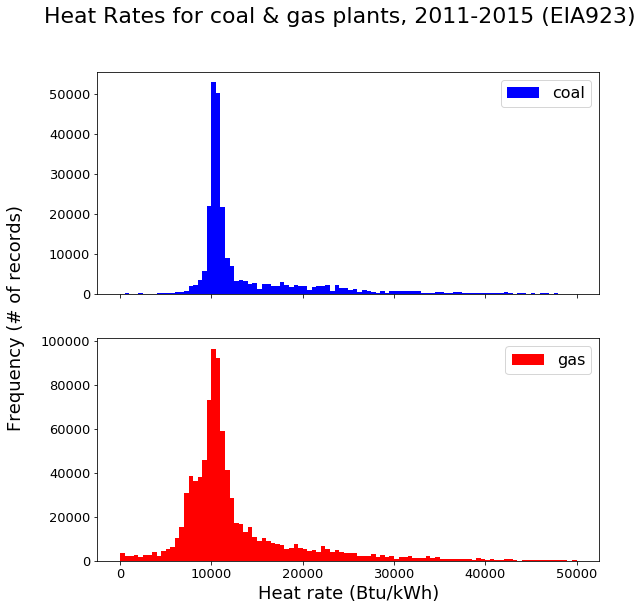

In [311]:
# Plot heat rate histogram for full data set by fuel type
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.hist(mwh_eia923_coal.calculated_heat_rate_btu_per_kwh, color= 'b', label='coal', range=(0,50000), bins=100)
ax1.legend(loc="upper right", fontsize=16)
ax1.yaxis.set_tick_params(labelsize=13)
ax2.hist(mwh_eia923_gas.calculated_heat_rate_btu_per_kwh, color= 'r', label='gas', range=(0,50000), bins=100)
ax2.legend(loc="upper right", fontsize=16)
plt.suptitle('Heat Rates for coal & gas plants, 2011-2015 (EIA923)', size=22)
ax2.set_xlabel('Heat rate (Btu/kWh)', size=18)
f.text(0.0, 0.5, 'Frequency (# of records)', ha='center', va='center', rotation='vertical', size=18)
f.set_size_inches(9,9)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.show()

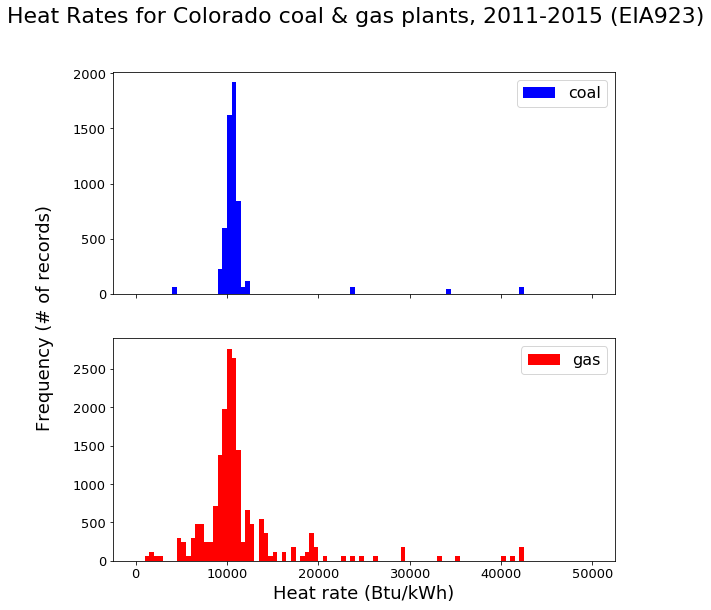

In [312]:
# Plot heat rate histogram for Colorado data set by fuel type
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.hist(mwh_eia923_co_coal.calculated_heat_rate_btu_per_kwh, color= 'b', label='coal', range=(0,50000), bins=100)
ax1.legend(loc="upper right", fontsize=16)
ax1.yaxis.set_tick_params(labelsize=13)
ax2.hist(mwh_eia923_co_gas.calculated_heat_rate_btu_per_kwh, color= 'r', label='gas', range=(0,50000), bins=100)
ax2.legend(loc="upper right", fontsize=16)
plt.suptitle('Heat Rates for Colorado coal & gas plants, 2011-2015 (EIA923)', size=22)
ax2.set_xlabel('Heat rate (Btu/kWh)', size=18)
f.text(0.02, 0.5, 'Frequency (# of records)', ha='center', va='center', rotation='vertical', size=18)
f.set_size_inches(9,9)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.show()

# Pull fuel_receipts_costs data from PUDL EIA923 tables


### Fuel_receipts_costs_eia923 gives info on heat content, fuel cost, and fuel purchase types

In [315]:
fuel_cost_eia923 = pd.read_sql('''SELECT plant_id, year, month, \
                                energy_source, fuel_group, contract_type, contract_expiration_date, coalmine_id, \
                                fuel_quantity, average_heat_content, average_sulfur_content \
                                average_ash_content, average_mercury_content, fuel_cost, primary_transportation_mode\
                                FROM fuel_receipts_costs_eia923 ''', pudl_engine)

### Pull fuel_receipts_costs_eia923 data just for the state of Colorado

In [316]:
fuel_cost_eia923_co = pd.read_sql('''SELECT plant_info_eia923.plant_state, fuel_receipts_costs_eia923.plant_id, \
                                year, month, energy_source, fuel_group, contract_type, contract_expiration_date, \
                                coalmine_id, fuel_quantity, average_heat_content, average_sulfur_content \
                                average_ash_content, average_mercury_content, fuel_cost, primary_transportation_mode \
                                FROM fuel_receipts_costs_eia923, plant_info_eia923 \
                                WHERE plant_info_eia923.plant_id = fuel_receipts_costs_eia923.plant_id \
                                AND plant_info_eia923.plant_state = 'CO' ''', pudl_engine)

In [317]:
# Add a day column in order to generate a datetime object ("date" column) to look at data as a time series
fuel_cost_eia923["day"] = int(1)
fuel_cost_eia923["date"] = pd.to_datetime(fuel_cost_eia923.year*10000+fuel_cost_eia923.month*100 + fuel_cost_eia923.day,format='%Y%m%d')

In [318]:
# Convert fuel costs from cents to dollars
fuel_cost_eia923['fuel_cost'] = fuel_cost_eia923['fuel_cost']/100

In [319]:
# Calculate heat_content_total by multiplying average_heat_content and fuel_quantity
fuel_cost_eia923["heat_content_total"] = fuel_cost_eia923.average_heat_content*fuel_cost_eia923.fuel_quantity

In [320]:
fuel_cost_eia923.head(1)

,plant_id,year,month,energy_source,fuel_group,contract_type,contract_expiration_date,coalmine_id,fuel_quantity,average_heat_content,average_ash_content,average_mercury_content,fuel_cost,primary_transportation_mode,day,date,heat_content_total
0,3,2011,1,BIT,Coal,C,1211.0,None,24076.0,22.66,0.59,NaN,5.444,RV,1,2011-01-01,545562.16


In [321]:
# Create data frames by fuel_group for all data
heat_content_coal = fuel_cost_eia923[(fuel_cost_eia923.fuel_group == 'Coal')]
heat_content_gas = fuel_cost_eia923[(fuel_cost_eia923.fuel_group == 'Natural Gas')]
heat_content_petroleum = fuel_cost_eia923[(fuel_cost_eia923.fuel_group == 'Petroleum')]
heat_content_petcoke = fuel_cost_eia923[(fuel_cost_eia923.fuel_group == 'Petroleum_Coke')]

In [322]:
# Create data frames by fuel_group for Colorado data
heat_content_coal_co = fuel_cost_eia923_co[(fuel_cost_eia923_co.fuel_group == 'Coal')]
heat_content_gas_co = fuel_cost_eia923_co[(fuel_cost_eia923_co.fuel_group == 'Natural Gas')]
heat_content_petroleum_co = fuel_cost_eia923_co[(fuel_cost_eia923_co.fuel_group == 'Petroleum')]
heat_content_petcoke_co = fuel_cost_eia923_co[(fuel_cost_eia923_co.fuel_group == 'Petroleum_Coke')]

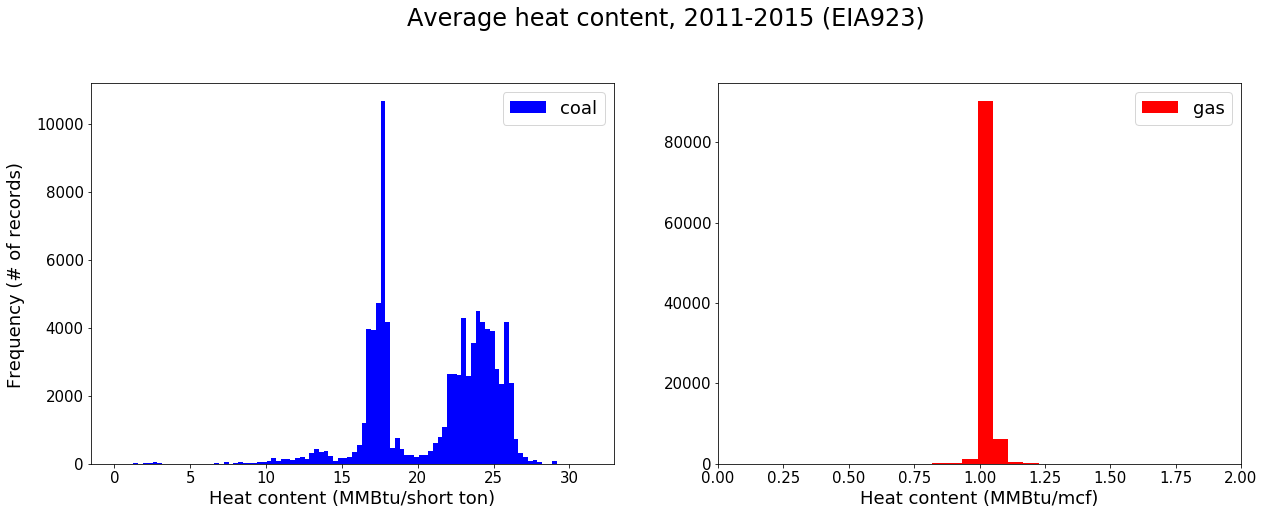

In [414]:
# Plot average heat content by fuel group
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(heat_content_coal.average_heat_content, color='b', label='coal', bins=100)
ax1.legend(loc="upper right", fontsize=18)
ax1.set_xlabel('Heat content (MMBtu/short ton)', size=18)
ax1.yaxis.set_tick_params(labelsize=15)
ax1.xaxis.set_tick_params(labelsize=15)
ax2.hist(heat_content_gas.average_heat_content, color= 'r', label='gas', bins=100)
ax2.set_xlim(0,2)
ax2.legend(loc="upper right", fontsize=18)
ax2.set_xlabel('Heat content (MMBtu/mcf)', size=18)
plt.text(-0.1, 1.2,'Average heat content, 2011-2015 (EIA923)', ha='center', 
         va='top', transform=ax2.transAxes, fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=15)
f.subplots_adjust(left=None, bottom=None, right=1.9, top=None, wspace=None, hspace=None)
f.set_size_inches(9,7)
f.text(.01, 0.5, 'Frequency (# of records)', ha='center', va='center', rotation='vertical', fontsize=18)
plt.show()

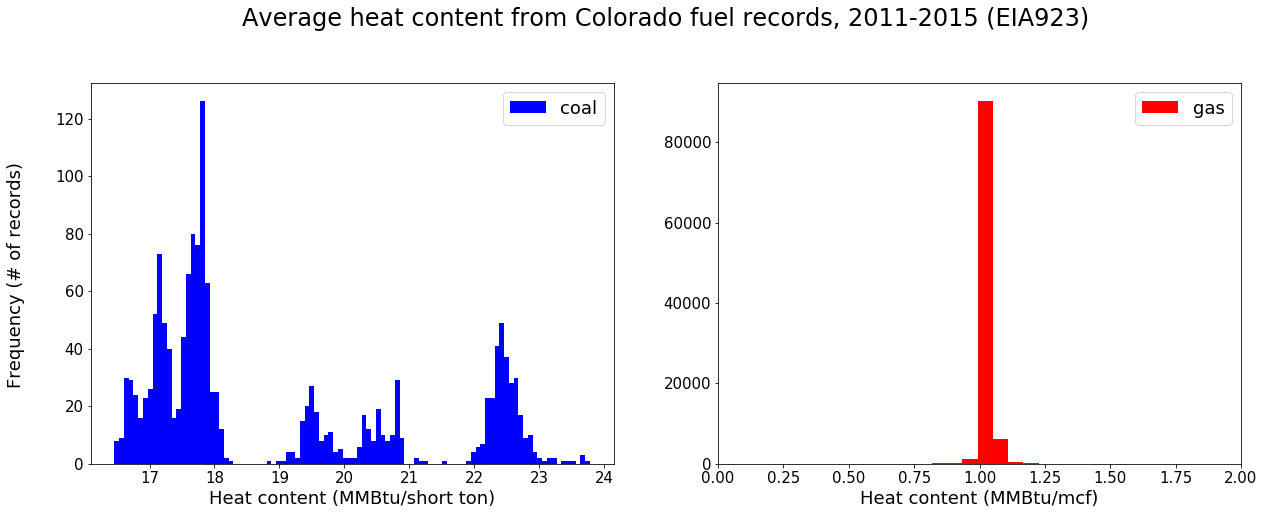

In [415]:
# Plot average heat content by fuel group for Colorado 
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(heat_content_coal_co.average_heat_content, color='b', label='coal', bins=100)
ax1.legend(loc="upper right", fontsize=18)
ax1.set_xlabel('Heat content (MMBtu/short ton)', size=18)
ax1.yaxis.set_tick_params(labelsize=15)
ax1.xaxis.set_tick_params(labelsize=15)
ax2.hist(heat_content_gas.average_heat_content, color= 'r', label='gas', bins=100)
ax2.set_xlim(0,2)
ax2.legend(loc="upper right", fontsize=18)
ax2.set_xlabel('Heat content (MMBtu/mcf)', size=18) 
plt.text(-0.1, 1.2,'Average heat content from Colorado fuel records, 2011-2015 (EIA923)', ha='center', 
         va='top', transform=ax2.transAxes, fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=15)
f.subplots_adjust(left=None, bottom=None, right=1.9, top=None, wspace=None, hspace=None)
f.set_size_inches(9,7)
f.text(.01, 0.5, 'Frequency (# of records)', ha='center', va='center', rotation='vertical', fontsize=18)
plt.show()

### Fuel cost analysis

In [381]:
# Median fuel cost per MMBtu in dollars
fuel_cost_eia923.fuel_cost.median()

3.4789999999999996

In [382]:
# Remove any negative fuel values 
positive_fuel = fuel_cost_eia923[fuel_cost_eia923['fuel_cost'] > 0]
# Since a NaN shows up here, it needs to be dropped
# TODO: check to see how many records are being dropped
# positive_fuel = positive_fuel.dropna(subset=['fuel_cost']) 
positive_fuel.fuel_cost.median()

3.48

In [383]:
# subset fuel_cost dataframes by fuel type
fuel_cost_coal = positive_fuel[(positive_fuel.fuel_group == 'Coal')]
fuel_cost_gas = positive_fuel[(positive_fuel.fuel_group == 'Natural Gas')]
fuel_cost_coal.shape

(61585, 17)

In [384]:
# Check maximum fuel cost for natural gas (in $)
fuel_cost_gas.fuel_cost.max()

235381.13

In [385]:
# Check maximum fuel cost for coal (in $)
fuel_cost_coal.fuel_cost.max()

32.670000000000002

In [388]:
# Natural gas fuel costs have high values that are unrealistic 
# Separate the values that are over $50/MMBtu
fuel_cost_gas_high = fuel_cost_gas[fuel_cost_gas['fuel_cost'] >50]
fuel_cost_gas = fuel_cost_gas[fuel_cost_gas['fuel_cost'] <=50]
fuel_cost_gas.fuel_cost.max()

39.701000000000001

In [387]:
# How many natural gas records exceed $50/MMBtu?
fuel_cost_gas_high.shape

(539, 17)

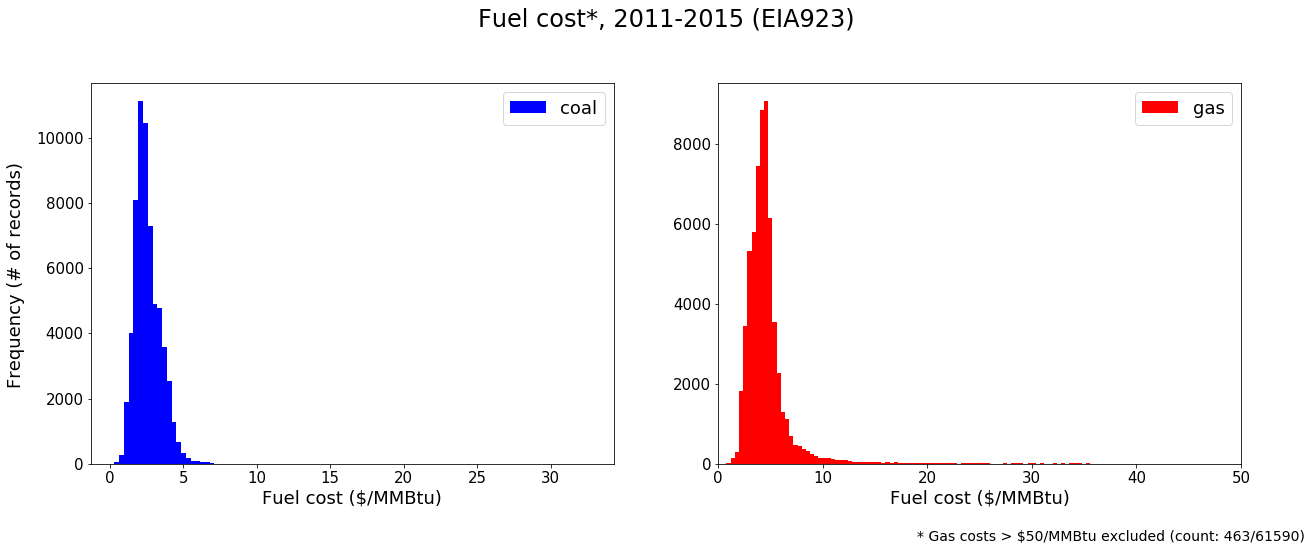

In [376]:
# Plot fuel cost per MMBtu by fuel group

f, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(fuel_cost_coal.fuel_cost, color='b', label='coal', bins=100)
ax1.legend(loc="upper right", fontsize=18)
ax1.set_xlabel('Fuel cost ($/MMBtu)', size=18)
ax1.yaxis.set_tick_params(labelsize=15)
ax1.xaxis.set_tick_params(labelsize=15)
ax2.hist(fuel_cost_gas.fuel_cost, color= 'r', label='gas', range=(0,40), bins=100)
ax2.set_xlim(0,50)
ax2.legend(loc="upper right", fontsize=18)
ax2.set_xlabel('Fuel cost ($/MMBtu)', size=18)
plt.text(-0.1, 1.2,'Fuel cost*, 2011-2015 (EIA923)', ha='center', 
         va='top', transform=ax2.transAxes, fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=15)
f.subplots_adjust(left=None, bottom=None, right=1.9, top=None, wspace=None, hspace=None)
f.set_size_inches(9,7)
f.text(.01, 0.5, 'Frequency (# of records)', ha='center', va='center', rotation='vertical', fontsize=18)

f.text(1.7, -0.02, '* Gas costs > $50/MMBtu excluded (count: 463/61590)', ha='center', va='center', fontsize=14)
plt.show()

### Look at fuel data by contract type

In [416]:
# Calculate a monthly sum of fuel quantity & fuel cost by fuel group and contract type
fuel_cost_eia923["monthly_fuel_quantity"] = fuel_cost_eia923.groupby(["year", "month", "fuel_group", "contract_type"])["fuel_quantity"].transform(sum)
fuel_cost_eia923["monthly_fuel_cost"] = fuel_cost_eia923.groupby(["year", "month", "fuel_group", "contract_type"])["fuel_cost"].transform(sum)

# Drop duplicates of monthly sums, so we lose indvidual purchase records but retain monthly data by contract type
fuel_cost_eia923 = fuel_cost_eia923.drop_duplicates(subset=['monthly_fuel_cost'])

# Look to see that duplicates have been dropped
fuel_cost_eia923.head(3)

,plant_id,year,month,energy_source,fuel_group,contract_type,contract_expiration_date,coalmine_id,fuel_quantity,average_heat_content,average_ash_content,average_mercury_content,fuel_cost,primary_transportation_mode,day,date,heat_content_total,monthly_fuel_quantity,monthly_fuel_cost
0,3,2011,1,BIT,Coal,C,1211.0,None,24076.0,22.66,0.59,NaN,5.444,RV,1,2011-01-01,545562.16,24076.0,5.444
2,3,2011,1,NG,Natural Gas,S,NaN,None,3645148.0,1.02,0.00,NaN,4.797,PL,1,2011-01-01,3718050.96,3645148.0,4.797
13,8,2011,1,DFO,Petroleum,C,311.0,None,717.0,5.86,0.50,NaN,15.856,TR,1,2011-01-01,4201.62,717.0,15.856


In [417]:
# Monthly records for coal purchased by contract
contract_buy_coal = fuel_cost_eia923[(fuel_cost_eia923.contract_type == 'C') & (fuel_cost_eia923.fuel_group == 'Coal')]

In [418]:
# Monthly records for natural gas purchased by contract
contract_buy_gas = fuel_cost_eia923[(fuel_cost_eia923.contract_type == 'C') & (fuel_cost_eia923.fuel_group == 'Natural Gas')]

In [419]:
# Monthly records for spot purchases of coal
spot_buy_coal = fuel_cost_eia923[(fuel_cost_eia923.contract_type == 'S') & (fuel_cost_eia923.fuel_group == 'Coal')]

In [420]:
# Monthly records for spot purchases of natural gas
spot_buy_gas = fuel_cost_eia923[(fuel_cost_eia923.contract_type == 'S') & (fuel_cost_eia923.fuel_group == 'Natural Gas')]

In [421]:
new_contract_buy_coal = fuel_cost_eia923[(fuel_cost_eia923.contract_type == 'NC') & (fuel_cost_eia923.fuel_group == 'Coal')]

In [422]:
new_contract_buy_gas = fuel_cost_eia923[(fuel_cost_eia923.contract_type == 'NC') & (fuel_cost_eia923.fuel_group == 'Natural Gas')]

In [413]:
# Look at coal purchased by contract
contract_buy_coal.head(3)

,plant_id,year,month,energy_source,fuel_group,contract_type,contract_expiration_date,coalmine_id,fuel_quantity,average_heat_content,average_ash_content,average_mercury_content,fuel_cost,primary_transportation_mode,day,date,heat_content_total,monthly_fuel_quantity,monthly_fuel_cost
0,3,2011,1,BIT,Coal,C,1211.0,None,24076.0,22.660,0.59,NaN,5.444,RV,1,2011-01-01,545562.160,73798083.0,2866.728
5012,3,2011,2,BIT,Coal,C,1211.0,None,102437.0,22.590,0.56,NaN,3.987,RV,1,2011-02-01,2314051.830,68624513.0,2918.048
9842,3,2011,3,BIT,Coal,C,1213.0,None,105067.0,22.576,0.55,NaN,3.981,RV,1,2011-03-01,2371992.592,74347346.0,2835.787


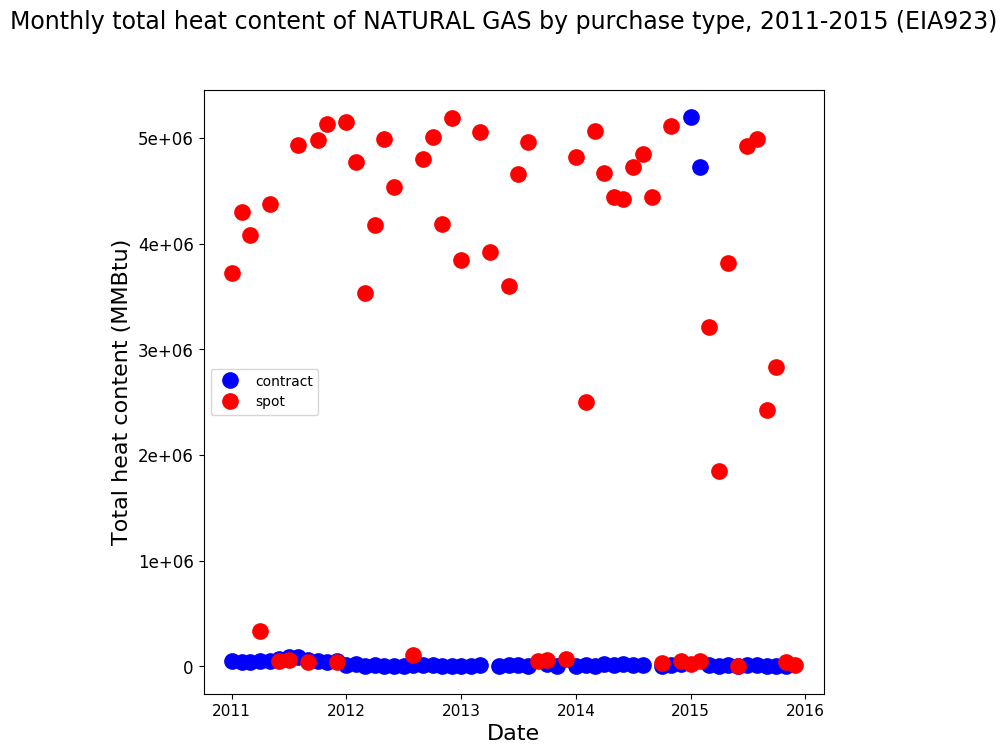

In [438]:
# Plot monthly total heat content for natural gas by contract type
fig = plt.figure(figsize=(8, 8), dpi=100)
plt.plot_date(x=contract_buy_gas.date, y=contract_buy_gas.heat_content_total, marker='o', markersize=11, color='b', label="contract")
plt.ylabel('Total heat content (MMBtu)', size=16)
plt.xlabel('Date', size=16)
plt.plot_date(x=spot_buy_gas.date, y=spot_buy_gas.heat_content_total, marker='o', markersize=11, color='r', label="spot")
plt.legend()
from matplotlib.ticker import FormatStrFormatter
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.xticks(size=11)
plt.yticks(size=12)
plt.suptitle('Monthly total heat content of NATURAL GAS by purchase type, 2011-2015 (EIA923)', size=17)
plt.show()

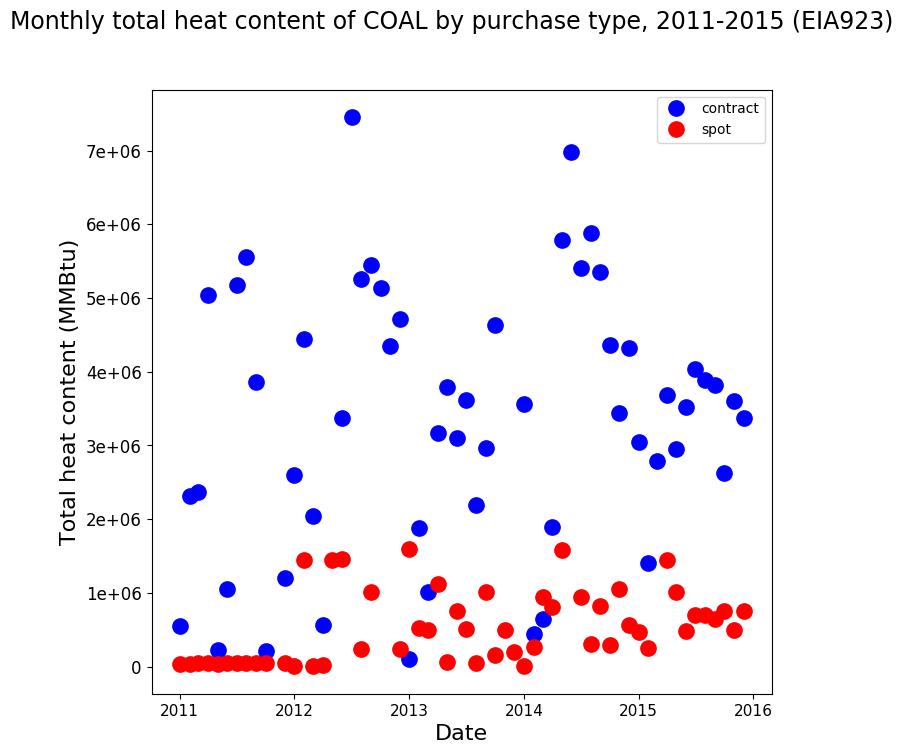

In [437]:
# Plot monthly total heat content for coal by contract type

fig = plt.figure(figsize=(8, 8), dpi=100)
plt.plot_date(x=contract_buy_coal.date, y=contract_buy_coal.heat_content_total, marker='o', markersize = 11, color='b', label="contract")
plt.ylabel('Total heat content (MMBtu)', size=16)
plt.xlabel('Date', size=16)
plt.plot_date(x=spot_buy_coal.date, y=spot_buy_coal.heat_content_total, marker='o', markersize=11, color='r', label="spot")
plt.legend()
from matplotlib.ticker import FormatStrFormatter
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.xticks(size=11)
plt.yticks(size=12)
plt.suptitle('Monthly total heat content of COAL by purchase type, 2011-2015 (EIA923)', size=17)
plt.show()

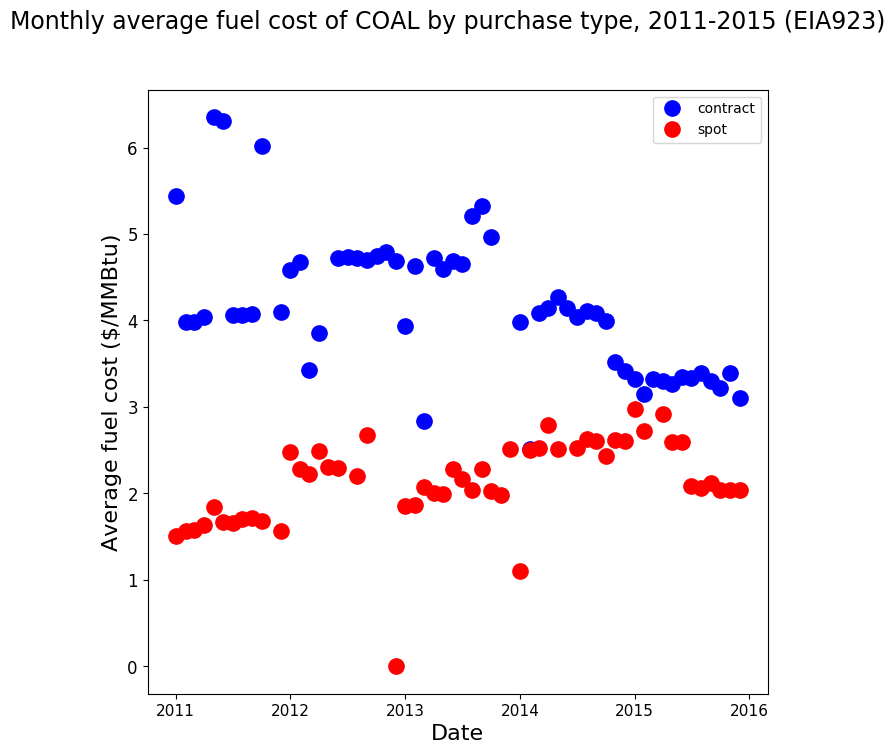

In [439]:
# Plot monthly fuel cost per MMBtu for coal by contract type

fig = plt.figure(figsize=(8, 8), dpi=100)
plt.plot_date(x=contract_buy_coal.date, y=contract_buy_coal.fuel_cost, marker='o', markersize = 11, color='b', label="contract")
plt.ylabel('Average fuel cost ($/MMBtu)', size=16)
plt.xlabel('Date', size=16)
plt.plot_date(x=spot_buy_coal.date, y=spot_buy_coal.fuel_cost, marker='o', markersize=11, color='r', label="spot")
plt.legend()
from matplotlib.ticker import FormatStrFormatter
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.xticks(size=11)
plt.yticks(size=12)
plt.suptitle('Monthly average fuel cost of COAL by purchase type, 2011-2015 (EIA923)', size=17)
plt.show()